# Modèle Student

##### Importations et configuration de l'environnement

In [1]:
import os
import sys
import torch

# Recherche automatique du dossier contenant les modules
sys.path.append(os.path.abspath("helper_student"))

from s_student_teacher_utils import inject_lora_modules, load_lora_weights_from_bin
from s_discriminator import Discriminator
from s_training_loop import train_student_with_adversarial
from s_metrics_utils import generate_comparison_images, compute_metrics

from diffusers import StableDiffusionPipeline, DDIMScheduler
from datasets import load_dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/root/addproject/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/addproject/env/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


#### 1. Chargement des modèles Teacher et Student
Initialisation du pipeline Stable Diffusion pour le teacher <br>
Injection des modules LoRA et chargement des poids entraînés. Le modèle student est une copie du teacher avec un scheduler plus rapide (4 étapes).

In [ ]:
import os
import sys
import torch

# Recherche automatique du dossier contenant les modules
sys.path.append(os.path.abspath("helper_student"))

from s_student_teacher_utils import inject_lora_modules, load_lora_weights_from_bin
from s_discriminator import Discriminator
from s_training_loop import train_student_with_adversarial
from s_metrics_utils import generate_comparison_images, compute_metrics

from diffusers import StableDiffusionPipeline, DDIMScheduler
from datasets import load_dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/root/addproject/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/addproject/env/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
teacher = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to(device)
inject_lora_modules(teacher.unet)
load_lora_weights_from_bin(teacher.unet, "./naruto_weights/teacher_lora_weights_10step_1batch_64.bin")

student = teacher.to("cuda")
student.scheduler.set_timesteps(num_inference_steps=4)


/root/addproject/env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/root/addproject/env/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]


✅ LoRA injecté dans 0 couches.
📦 Chargement des poids LoRA depuis : ./naruto_weights/teacher_lora_weights_10step_1batch_64.bin
🔁 32/32 modules LoRA mis à jour.


#### 2. Initialisation du Discriminateur

In [3]:
discriminator = Discriminator().to(device)

#### 3. Préparation du Dataset Naruto

In [4]:
dataset = load_dataset("lambdalabs/naruto-blip-captions", split="train")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

def transform_example(example):
    image = example["image"].convert("RGB")
    example["pixel_values"] = transform(image)
    return example

dataset = dataset.map(transform_example)

def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(x["pixel_values"]) for x in batch])
    prompts = [x["text"] for x in batch]
    return pixel_values, prompts

train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)


Repo card metadata block was not found. Setting CardData to empty.


#### 4. Entraînement du Student avec Perte SDS + Adversaire

Initialisation du scheduler DDIM, sélection des paramètres LoRA entraînables, définition des optimiseurs pour le student et le discriminateur. <br>
L’entraînement combine une perte de reconstruction (SDS) avec une perte adversaire pour améliorer la qualité des images générées.

In [5]:
scheduler = DDIMScheduler.from_config(student.scheduler.config)
scheduler.set_timesteps(num_inference_steps=4)

# Sélection des poids LoRA entraînables
lora_params = []
for name, module in student.unet.attn_processors.items():
    if isinstance(module, torch.nn.Module):
        module.to(device)
        for param in module.parameters():
            param.requires_grad = True
            lora_params.append(param)

optimizer_student = torch.optim.Adam(lora_params, lr=1e-5)
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=1e-5)

train_student_with_adversarial(
    student, teacher,
    dataloader=train_dataloader,
    discriminator=discriminator,
    scheduler=scheduler,
    optimizer_student=optimizer_student,
    optimizer_disc=optimizer_disc,
    lambda_adv=0.5,
    epochs=2
)


Epoch 0:   0%|          | 0/1221 [00:00<?, ?it/s]/root/addproject/env/lib/python3.12/site-packages/diffusers/models/attention_processor.py:1871: FutureWarning: `LoRAAttnProcessor` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(
Epoch 1: 100%|██████████| 1221/1221 [06:24<00:00,  3.17it/s, d_loss=0.659, s_loss=0.529, sds=0.144]  


#### 5. Génération d’Images : Student vs Teacher

Comparaison visuelle entre le modèle Student (25 étapes) et le modèle Teacher (100 étapes) sur un même prompt.

100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


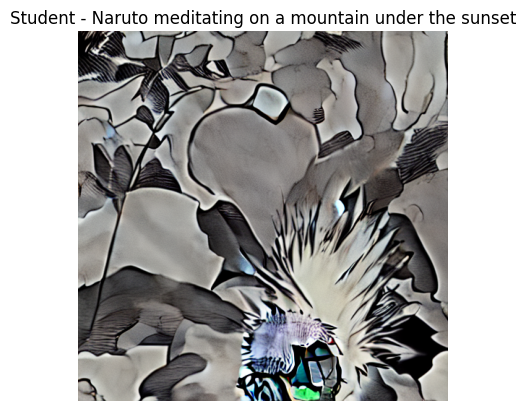

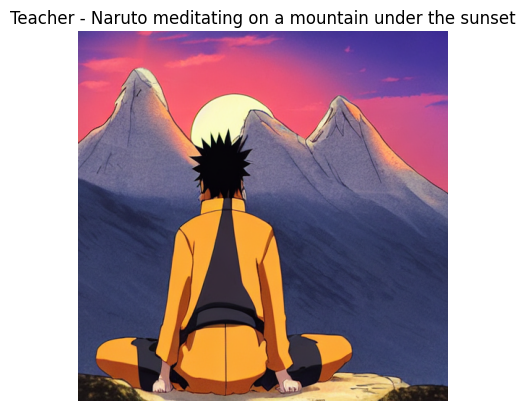

In [6]:
prompt = "Naruto meditating on a mountain under the sunset"
student.to("cuda")
teacher.to("cuda")

# Désactiver NSFW + set eval mode
for pipe in [teacher, student]:
    pipe.unet.eval()
    pipe.vae.eval()
    pipe.text_encoder.eval()
    pipe.safety_checker = None

with torch.autocast("cuda"):
    result_student = student(prompt=prompt, num_inference_steps=4, guidance_scale=7.5)
    result_teacher = teacher(prompt=prompt, num_inference_steps=100)

plt.imshow(result_student.images[0])
plt.title("Student - " + prompt)
plt.axis("off")
plt.show()

plt.imshow(result_teacher.images[0])
plt.title("Teacher - " + prompt)
plt.axis("off")
plt.show()


#### 6. Évaluation Quantitative : FID & LPIPS + Meilleures Générations

In [7]:
prompts_test = dataset.select(range(10))["text"]
teacher_imgs, student_imgs = generate_comparison_images(teacher, student, prompts_test, device="cuda")
fid_score, lpips_score = compute_metrics(teacher_imgs, student_imgs, device="cuda")

Génération d'images pour métriques: 100%|██████████| 10/10 [03:40<00:00, 22.06s/it]
/root/addproject/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/addproject/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



📊 Comparaison Student vs Teacher:
FID Score : 286.3204
LPIPS Score : 0.7306 (plus proche de 0 = plus proche visuellement)


In [ ]:
prompts_test = dataset.select(range(10))["text"]
teacher_imgs, student_imgs, image_pairs = generate_comparison_images(teacher, student, prompts_test, device="cuda")
fid_score, lpips_score = compute_metrics(teacher_imgs, student_imgs, image_pairs, device="cuda", top_k=3)
